In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# Acquire data

In [2]:
data = pd.read_csv('data/ativa_data.csv')

In [3]:
data.head()

,id,price,type,rooms,neighborhood,suites,bathrooms,garages,private_area,total_area
0,1,468000,Apartamento,3,Jardim La Salle,1,2,2,89.27,0.00
1,2,680000,Apartamento,3,Centro,1,2,1,120.00,168.42
2,3,230000,Casa,2,São Francisco,0,1,1,65.94,128.30
3,4,580000,Casa,3,Jardim Gisela,1,2,2,107.97,180.00
4,5,270000,Casa,2,Jardim Panorama,1,2,2,70.00,166.67


# Analyze by describing data

## Which features are available in the dataset?

In [4]:
data.columns.values

array(['id', 'price', 'type', 'rooms', 'neighborhood', 'suites',
       'bathrooms', 'garages', 'private_area', 'total_area'], dtype=object)

## Which features are categorical?

'type' and 'neighborhood'

## Which features are numerical?

price, rooms, suites, bathrooms, garages, private_area, total_area

## Which features may contain errors or typos?

Apparently there is no errors

In [5]:
data.sample(15)

,id,price,type,rooms,neighborhood,suites,bathrooms,garages,private_area,total_area
122,123,249000,Casa,2,Jardim Coopagro,1,2,2,54.00,125.00
999,1000,998000,Apartamento,3,Centro,1,4,2,158.04,0.00
459,460,559000,Apartamento,3,Vila Industrial,1,2,2,85.00,0.00
796,797,630000,Apartamento,3,Centro,3,4,2,161.37,195.67
725,726,344363,Apartamento,2,Centro,1,2,1,55.48,0.00
659,660,2700000,Apartamento,3,Centro,3,4,2,289.46,0.00
209,210,305000,Apartamento,2,Jardim Santa Maria,0,1,1,55.26,85.60
302,303,244000,Casa,2,Jardim Coopagro,1,2,2,54.00,125.00
681,682,471950,Apartamento,2,Centro,1,2,1,79.25,0.00
429,430,342125,Apartamento,2,Jardim Pancera,1,2,1,67.00,0.00


## Which features contain blank, null or empty values?

2 features have empty values:

private_area % 0.89

total_area % 45.08

In [6]:
mask1 = data.private_area == 0
mask2 = data.total_area == 0

print('private_area %', data[mask1].shape[0]/data.shape[0]*100)
print('total_area %', data[mask2].shape[0]/data.shape[0]*100)

private_area % 0.8944543828264758
total_area % 45.08050089445438


In [7]:
data.describe()

,id,price,rooms,suites,bathrooms,garages,private_area,total_area
count,1118.000000,1.118000e+03,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000
mean,559.500000,5.490504e+05,2.501789,0.843470,1.983900,1.481216,103.945125,136.373953
std,322.883106,4.269139e+05,0.652450,0.697615,0.815972,0.745686,60.965019,188.499500
min,1.000000,2.500000e+02,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,280.250000,3.000000e+05,2.000000,0.000000,1.000000,1.000000,61.850000,0.000000
50%,559.500000,4.000000e+05,2.000000,1.000000,2.000000,1.000000,84.850000,89.550000
75%,838.750000,6.395000e+05,3.000000,1.000000,2.000000,2.000000,121.977500,198.167500
max,1118.000000,4.016586e+06,6.000000,4.000000,7.000000,7.000000,690.000000,1800.000000


# dealing with empty values

We need deal with zero values of private area and total_area

for private_area we can just drop the rows missing since its less than 1%.

for total_area we may want to drop since 45% is missing

In [4]:
mask1 = data.private_area != 0
data = data[mask1]

In [5]:
data = data.drop(columns=['total_area', 'id'])

# analysing 'SalePrice'

In [50]:
data['price'].describe()

count    1.108000e+03
mean     5.491140e+05
std      4.277999e+05
min      2.500000e+02
25%      3.000000e+05
50%      4.000000e+05
75%      6.385000e+05
max      4.016586e+06
Name: price, dtype: float64

## Histogram

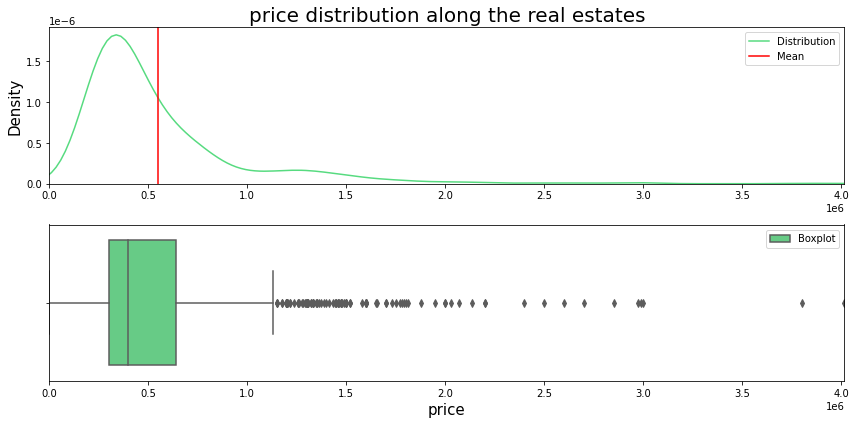

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 6));
color=sns.color_palette("hls", 8)[3]

sns.kdeplot(x="price", data=data, color=color, ax=axes[0], label='Distribution');
axes[0].tick_params(labelsize=10)
axes[0].set_title('price distribution along the real estates', fontsize=20)
# axes[0].set_xlabel('Gross', fontsize=15)
axes[0].set_xlabel('', fontsize=15)
axes[0].set_ylabel('Density', fontsize=15)
axes[0].set_xlim(0, data['price'].max())
axes[0].axvline(data['price'].mean(), color='red', label='Mean')
axes[0].legend()

sns.boxplot(x="price", data=data, color=color, ax=axes[1]);
axes[1].tick_params(labelsize=10)
# axes[1].set_title('Gross division along the movies', fontsize=20)
axes[1].set_xlabel('price', fontsize=15)
axes[1].set_xlim(0, data['price'].max())
axes[1].legend(['Boxplot'])
plt.tight_layout();
plt.show();

In [13]:
#skewness and kurtosis
print("Skewness: %f" % data['price'].skew())
print("Kurtosis: %f" % data['price'].kurt())

Skewness: 2.884859
Kurtosis: 12.386800


## Observations

* Deviate from the normal distribution.
* Have appreciable positive skewness.
* Show peakedness.

# Analyse by visualizing data

## Correlation

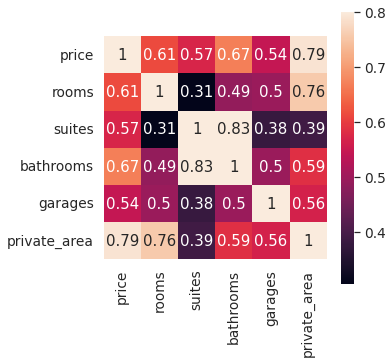

In [24]:
#correlation matrix
corrmat = data.corr(method='spearman')
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

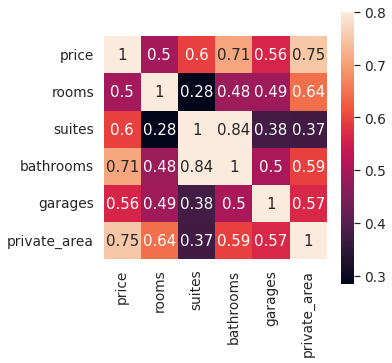

In [25]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

## Relationship with numerical variables

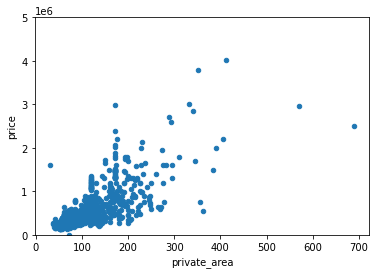

In [43]:
var = 'private_area'
data_aux = pd.concat([data['price'], data[var]], axis=1)
data_aux.plot.scatter(x=var, y='price', ylim=(0, 5000000));

## Relationship with categorical features

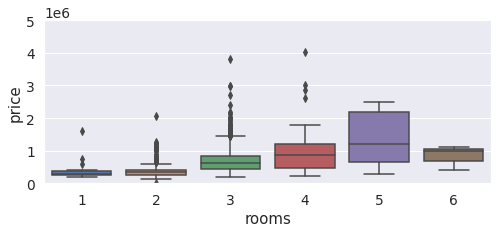

In [26]:
var = 'rooms'
data_aux = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 3))
fig = sns.boxplot(x=var, y="price", data=data_aux)
fig.axis(ymin=0, ymax=5000000);

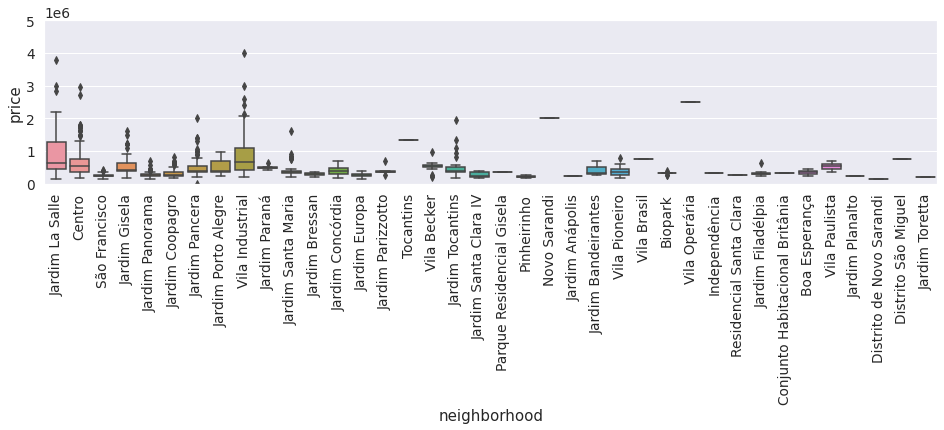

In [27]:
var = 'neighborhood'
data_aux = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 3))
fig = sns.boxplot(x=var, y="price", data=data_aux)
fig.axis(ymin=0, ymax=5000000);
plt.xticks(rotation=90);

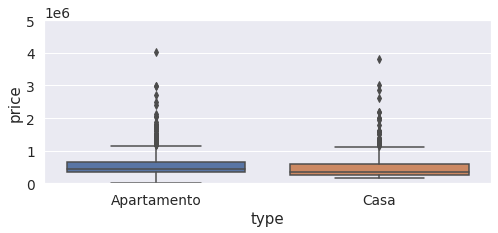

In [28]:
var = 'type'
data_aux = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 3))
fig = sns.boxplot(x=var, y="price", data=data_aux)
fig.axis(ymin=0, ymax=5000000);

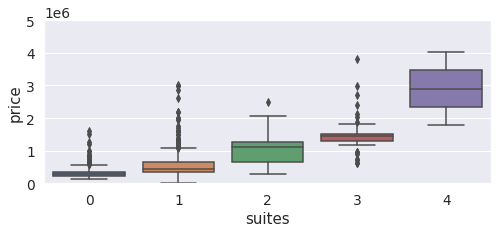

In [29]:
var = 'suites'
data_aux = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 3))
fig = sns.boxplot(x=var, y="price", data=data_aux)
fig.axis(ymin=0, ymax=5000000);

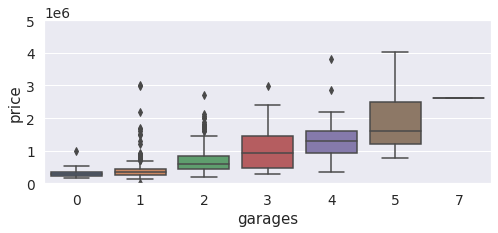

In [30]:
var = 'garages'
data_aux = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 3))
fig = sns.boxplot(x=var, y="price", data=data_aux)
fig.axis(ymin=0, ymax=5000000);

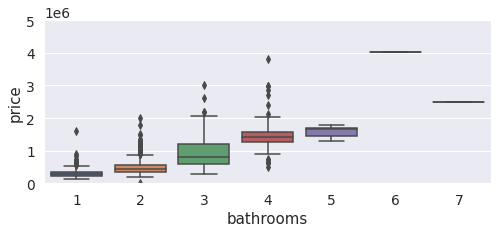

In [31]:
var = 'bathrooms'
data_aux = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 3))
fig = sns.boxplot(x=var, y="price", data=data_aux)
fig.axis(ymin=0, ymax=5000000);

## Observations

with exception of type and neighborhood all features have a strong influence on price

# Outliars

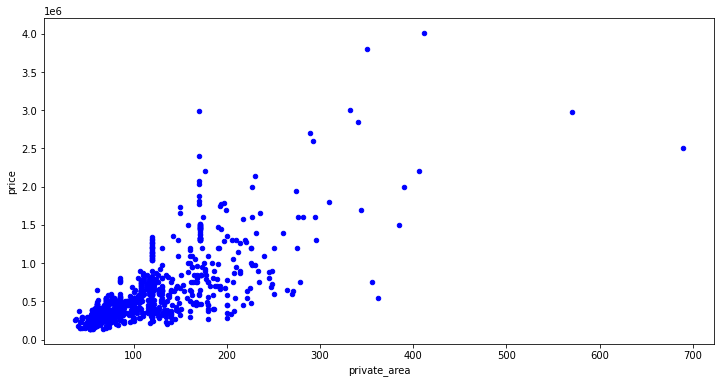

In [8]:
var = 'private_area'
data_aux = pd.concat([data['price'], data[var]], axis=1)
# data_aux = np.log(data_aux)
data_aux.plot.scatter(x=var, y='price', figsize=(12,6), color='b');

In [7]:
#deleting points
data = data.drop(data[data.index == 1061].index)
data = data.drop(data[data.index == 780].index)

# Rescale

In [9]:
# data['private_area'], lambda_private_area = boxcox(data['private_area'])
# data['price'], lambda_price = boxcox(data['price'])

data['private_area'] = np.log(data['private_area'])
data['price'] = np.log(data['price'])

/media/desktop-mint/Dados/Projetos/Scrapy/scrapy_real_estate/env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


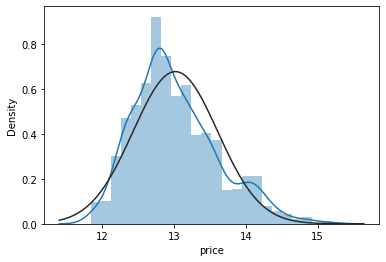

In [10]:
sns.distplot(data['price'], fit=norm);

/media/desktop-mint/Dados/Projetos/Scrapy/scrapy_real_estate/env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


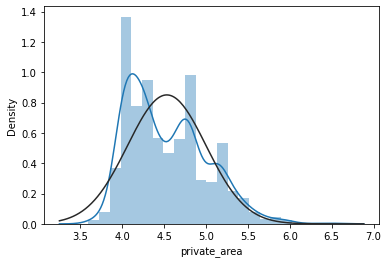

In [11]:
sns.distplot(data['private_area'], fit=norm);

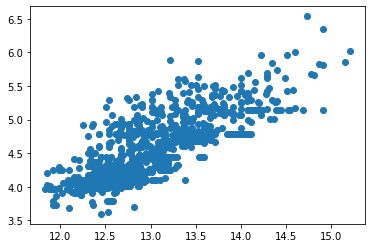

In [12]:
plt.scatter(data['price'], data['private_area']);

# Model

In [13]:
cols = ['price',  'rooms',
        'suites', 'bathrooms',
        # 'type',   'neighborhood',
        'garages', 'private_area'
       ]

data_model = pd.get_dummies(data[cols])

X = data_model.drop(columns=['price'])
y = data_model['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .30, random_state = 0)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((774, 5), (774,), (332, 5), (332,))

In [15]:
## Call in the LinearRegression object
# lin_reg = LinearRegression(normalize=True, n_jobs=-1)
lin_reg = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
## fit train and test data. 
lin_reg.fit(X_train, y_train)
## Predict test data.
y_pred = lin_reg.predict(X_test)

In [16]:
print('%.8f'%mean_squared_error(y_test, y_pred))

0.08542452


In [17]:
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, X,y, cv = cv, scoring = 'neg_mean_absolute_error')
print ('%.8f'%scores.mean())
print ('%.8f'%scores.std())

-0.22910813
0.02559960


/media/desktop-mint/Dados/Projetos/Scrapy/scrapy_real_estate/env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


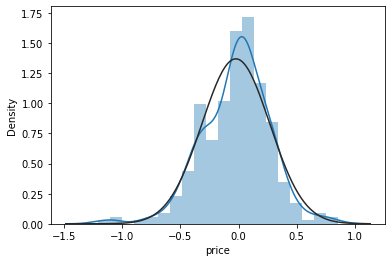

In [19]:
sns.distplot(y_test - y_pred, fit=norm);

In [18]:
# rescale_y_test = inv_boxcox(y_test, lambda_price)
# rescale_y_pred = inv_boxcox(y_pred, lambda_price)

rescale_y_test = np.exp(y_test)
rescale_y_pred = np.exp(y_pred)

print('%.4f'%np.sqrt(mean_squared_error(rescale_y_test, rescale_y_pred)))

188252.9547


/media/desktop-mint/Dados/Projetos/Scrapy/scrapy_real_estate/env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


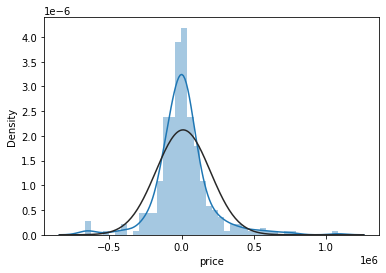

In [20]:
sns.distplot(rescale_y_test - rescale_y_pred, fit=norm);

In [24]:
#std
np.std(rescale_y_test - rescale_y_pred)

187998.5360347948

In [23]:
#CV
np.std(rescale_y_test - rescale_y_pred)/np.mean(rescale_y_test - rescale_y_pred)

19.215022835537937